In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from model.utils import train_one_epoch, evaluate
from query.margin import margin_query
import numpy as np
import copy
import random
from matplotlib.lines import Line2D
plt.style.use('bmh')

In [2]:
@torch.no_grad()
def plot_contour(model, X_l, y_l, X_u, y_u, db_color='black', ax=None):
    model.eval()
    model.cpu()
    origin = 'lower'
    if ax:
        plt.sca(ax)
    xx, yy = torch.meshgrid(torch.linspace(-1.5, 2.5, 51), torch.linspace(-1, 1.5, 51), indexing='ij')
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    plt.scatter(X_u[:, 0], X_u[:, 1], c=y_u,)
    plt.scatter(X_l[:, 0], X_l[:, 1], c=y_l, edgecolors='red')
    CS = plt.contourf(xx, yy, zz, alpha=0, zorder=-1, levels=np.linspace(0, 1, 6), origin=origin)
    CS2 = plt.contour(CS, levels=[0.5], colors=db_color, origin=origin)

In [3]:
class SimpleNet(nn.Module):
    def __init__(self, num_classes: int, dropout_rate: int = 0, feature_dim: int = 128):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = nn.Dropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x, return_feature=False):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        if return_feature:
            return out, x
        return out
    
    @torch.no_grad()
    def get_logits(self, dataloader, device):
        self.to(device)
        all_logits = []
        for samples, _ in dataloader:
            logits = self(samples.to(device))
            all_logits.append(logits)
        return torch.cat(all_logits)


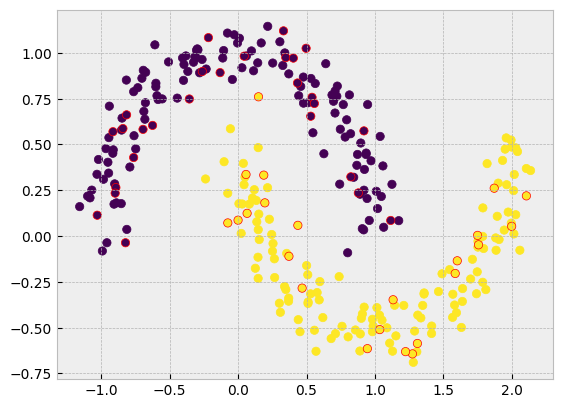

In [4]:
n_samples = 300
test_size = 50
X,y = make_moons(n_samples=n_samples, noise=0.1, random_state=1)
X,y = torch.tensor(X).float(), torch.tensor(y).long()
random.seed(1)
test_indices = random.sample(range(n_samples), test_size)
train_indices = [i for i in range(n_samples) if i not in test_indices]
dataset = TensorDataset(X, y)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
plt.scatter(x=X[train_indices,0], y=X[train_indices,1], c=y[train_indices])
plt.scatter(x=X[test_indices,0], y=X[test_indices,1], c=y[test_indices], edgecolors='red')
plt.show()

In [5]:
def dal_experiment(model, labeled_indices, train_dataset, n_queries, n_epochs=50, test_dataset=None, query_size=2, batch_size=8, lr=5e-2, weight_decay=1e-5, seed=42, device='cuda'):
    optimizer = torch.optim.SGD(
        params=model.parameters(),
        lr=5e-2,
        momentum=0.9,
        weight_decay=1e-5,
        nesterov=True
    )
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer=optimizer, 
        T_max=n_epochs)
    criterion = torch.nn.CrossEntropyLoss()

    initial_model_state = copy.deepcopy(model.state_dict())
    initial_optimizer_state = copy.deepcopy(optimizer.state_dict())
    initial_lr_scheduler_state = copy.deepcopy(lr_scheduler.state_dict())

    unlabeled_indices = [i for i in range(len(train_dataset)) if i not in labeled_indices]

    history = []
    for i_cycle in range(n_queries):
        if i_cycle != 0:
            newly_labeled_indices = margin_query(
                model=model,
                budget=query_size,
                labeled_indices=labeled_indices, 
                unlabeled_indices=unlabeled_indices,
                query_dset=dataset,
                device=device
            )
            labeled_indices += newly_labeled_indices
            unlabeled_indices = [i for i in range(len(train_dataset)) if i not in labeled_indices]

        model.load_state_dict(initial_model_state)
        optimizer.load_state_dict(initial_optimizer_state)
        lr_scheduler.load_state_dict(initial_lr_scheduler_state)
        labeled_dset = Subset(train_dataset, labeled_indices)
        train_loader = DataLoader(dataset=labeled_dset, batch_size=batch_size, drop_last=len(labeled_indices) > batch_size, shuffle=True)
        train_history = []
        for _ in range(n_epochs):
            train_stats = train_one_epoch(train_loader, model, optimizer, criterion)
            train_history.append(train_stats)
            lr_scheduler.step()

        if test_dataset:
            test_loader = DataLoader(dataset=test_dataset, batch_size=16)
            test_stats = evaluate(model=model, dataloader=test_loader, criterion=criterion)

        history.append((train_history, test_stats))

    return model, labeled_indices, history

In [6]:
n_epochs = 50
n_queries = 4
initial_size = 2
batch_size = 8
query_size = 2
lr = 5e-2
wd = 5e-5
hidden_dim_size = 512
n_other_models = 5
device = 'cuda'
seed = 37
torch.manual_seed(seed)
random.seed(seed)

model = SimpleNet(2, 0, hidden_dim_size)
optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=wd,
    nesterov=True
)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer, 
    T_max=n_epochs)
criterion = torch.nn.CrossEntropyLoss()

initial_model_state = copy.deepcopy(model.state_dict())
initial_optimizer_state = copy.deepcopy(optimizer.state_dict())
initial_lr_scheduler_state = copy.deepcopy(lr_scheduler.state_dict())

initial_labeled_indices = random.sample(range(len(train_dataset)), k=initial_size)
labeled_indices = [i for i in initial_labeled_indices]
unlabeled_indices = [i for i in range(len(train_dataset)) if i not in labeled_indices]

for i_cycle in range(n_queries):
    if i_cycle != 0:
        newly_labeled_indices = margin_query(
            model=model,
            budget=query_size,
            labeled_indices=labeled_indices, 
            unlabeled_indices=unlabeled_indices,
            query_dset=dataset,
            device=device
        )
        labeled_indices += newly_labeled_indices
        unlabeled_indices = [i for i in range(len(train_dataset)) if i not in labeled_indices]

    model.load_state_dict(initial_model_state)
    optimizer.load_state_dict(initial_optimizer_state)
    lr_scheduler.load_state_dict(initial_lr_scheduler_state)

    labeled_dset = Subset(train_dataset, labeled_indices)
    train_loader = DataLoader(dataset=labeled_dset, batch_size=batch_size, drop_last=len(labeled_indices) > batch_size, shuffle=True)
    for i_epoch in range(n_epochs):
        train_stats = train_one_epoch(train_loader, model, optimizer, criterion)
        lr_scheduler.step()

    test_loader = DataLoader(dataset=test_dataset, batch_size=16)
    test_stats = evaluate(model=model, dataloader=test_loader, criterion=criterion)


print(seed)
print(f"[Primary Model][Final Pool]","Test Accuracy:",test_stats['acc1'])


# Evaluate multiple other models
if 1:
    other_models = []
    for o in range(n_other_models):
        second_model = SimpleNet(2, 0, random.choice(range(64, 2*hidden_dim_size)))
        second_optimizer = torch.optim.SGD(
            params=second_model.parameters(),
            lr=random.choice([i/1000 for i in range(50, 500)]),
            momentum=0.9,
            weight_decay=random.choice([i/10000 for i in range(5, 1000)]),
            nesterov=True
        )
        second_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer=second_optimizer, 
            T_max=n_epochs)

        for i_epoch in range(n_epochs):
            train_stats = train_one_epoch(train_loader, second_model, second_optimizer, criterion)
            second_lr_scheduler.step()

        test_stats = evaluate(model=second_model, dataloader=test_loader, criterion=criterion)
        print(f"[Model {o}][Final Pool]","Test Accuracy:",test_stats['acc1'])
        other_models.append(copy.deepcopy(second_model))
else:
    other_models = []

37
[Primary Model][Final Pool] Test Accuracy: 98.0
[Model 0][Final Pool] Test Accuracy: 80.0
[Model 1][Final Pool] Test Accuracy: 88.0
[Model 2][Final Pool] Test Accuracy: 94.0
[Model 3][Final Pool] Test Accuracy: 80.0
[Model 4][Final Pool] Test Accuracy: 96.0


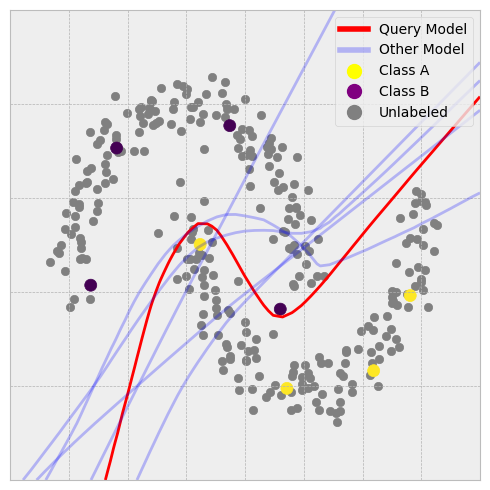

In [10]:
fig = plt.figure(figsize=(5, 5), tight_layout=True)
plt.scatter(X[:, 0], X[:, 1], c='gray')
plt.scatter(X[train_indices][labeled_indices][:, 0], X[train_indices][labeled_indices][:, 1], c=y[train_indices][labeled_indices], marker='o', s=75)
xx, yy = torch.meshgrid(torch.linspace(-1.5, 2.5, 51), torch.linspace(-1, 1.5, 51), indexing='ij')
zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)
origin = 'lower'
for i, m in enumerate([model] + other_models):
    m.eval()
    m.cpu()
    logits = m(zz)
    probas = logits.softmax(-1)
    blub = probas[:, 1].view(xx.shape).detach()
    CS = plt.contourf(xx, yy, blub, alpha=0, zorder=-1, levels=np.linspace(0, 1, 6), origin=origin)
    CS2 = plt.contour(CS, levels=[0.5], colors='red' if i == 0 else 'blue', origin=origin, alpha=0.25 if i > 0 else 1)
custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=4, alpha=0.25),
                Line2D([], [], linewidth=0, marker='o', markersize=10, markerfacecolor="yellow", markeredgecolor="yellow"),
                Line2D([], [], linewidth=0, marker='o', markersize=10, markerfacecolor="purple", markeredgecolor="purple"),
                Line2D([], [], linewidth=0, marker='o', markersize=10, markerfacecolor="gray", markeredgecolor="gray")]
plt.legend(custom_lines, ['Query Model', 'Other Model', 'Class A', 'Class B', 'Unlabeled'])
plt.grid(True)
plt.tick_params(
    axis='both',        
    which='both',      
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off
#plt.show()
plt.savefig('/home/phahn/repositories/SDAL/images/graphical_abstract_a.pdf', bbox_inches='tight')

In [8]:
# Repeat DAL experiments for other models and count the number of overlapping labeled samples to show model dependency of querying.
lab_pools = []
for mo in other_models:
    m, l, h = dal_experiment(model=mo, labeled_indices=[i for i in initial_labeled_indices], train_dataset=train_dataset, n_queries=n_queries, n_epochs=n_epochs, test_dataset=test_dataset, query_size=query_size, batch_size=batch_size, lr=lr, weight_decay=wd)
    lab_pools.append(l)

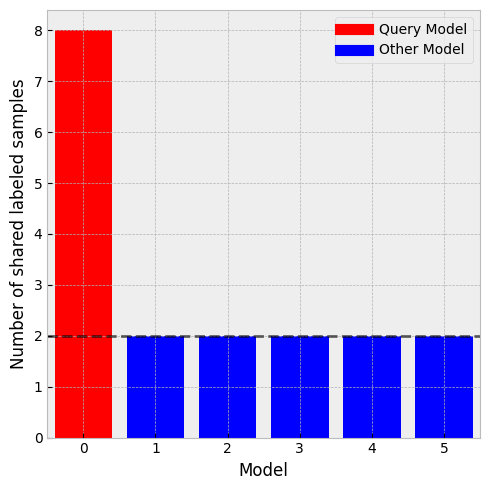

In [9]:
equal_indices = []
for lab in lab_pools:
    eq = sum([1 for i in lab if i in labeled_indices])
    equal_indices.append(eq)

plt.figure(figsize=(5,5), tight_layout=True)
colors = ['red']+['blue' for i in range(len(equal_indices))]
plt.bar(x=range(len(equal_indices)+1), height=[len(labeled_indices)]+equal_indices, color=colors)
plt.grid(True)
plt.hlines(y=initial_size, xmin=-0.5, xmax=len(colors)-0.5, colors='black', linewidth=2., linestyles='--', alpha=0.6)
plt.xlim(-0.5, len(colors)-0.5)
plt.xlabel('Model')
plt.ylabel('Number of shared labeled samples')
custom_lines = [Line2D([0], [0], color='red', lw=8),
                Line2D([0], [0], color='blue', lw=8)]
plt.legend(custom_lines, ['Query Model', 'Other Model'])

#plt.show()
plt.savefig('/home/phahn/repositories/SDAL/images/graphical_abstract_b.pdf', bbox_inches='tight')